# Demonstration: Low-pass Filtered Additive White Gaussian Noise (AWGN)

In [1]:
# import necessary libraries
import numpy as np                   # basic vector / matrix tools, numerical math
from matplotlib import pyplot as plt # Plotting
import seaborn                       # prettier plots
import math                          # General math functions
from scipy import signal, stats      # Signal analysis, filter design; statistic/stochastics

# Show all plots inline (not in new window), make text large, and fix the figure size
%matplotlib inline
seaborn.set(font_scale=2)
plt.rc("figure", figsize = (1200/72, 400/72), dpi=72)

# Generate noisy samples
Draw real and imaginary part of each sample from independent normal distributions:

In [2]:
# Time reference: 
T_S = 1e-6          # seconds
f_S = 1 / T_S       # sampling frequency
f_nyquist = f_S / 2 # nyquist frequency

print("""
Sampling rate:     {rate} kHz
Sample period:     {period} µs
Nyquist frequency: {nyquist} kHz""".format(rate=f_S/1000, period=T_S*1e6, nyquist=f_nyquist/1000))


Sampling rate:     1000.0 kHz
Sample period:     1.0 µs
Nyquist frequency: 500.0 kHz


In [3]:
N_0 = 1;                     # W/Hz
variance = N_0*f_S/2         # variance of each component (I, Q)
sigma = math.sqrt(variance)  # standard deviation of each component
num_samples = 10000          # number of samples (= length of vector)

complex_noisy_samples = np.random.normal(0, sigma, num_samples)\
                 + 1j * np.random.normal(0, sigma, num_samples)

# Noise samples in complex plane

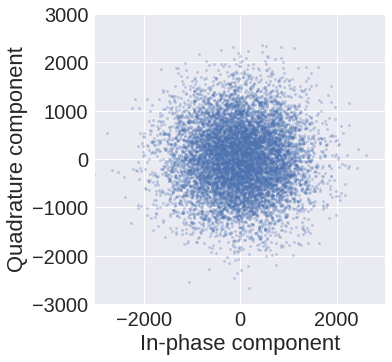

In [4]:
plt.axis('square');
plt.scatter(complex_noisy_samples.real, complex_noisy_samples.imag, s=6, alpha=0.3)
plt.xlim(-3000, 3000); plt.ylim(-3000, 3000)
plt.xlabel('In-phase component'); plt.ylabel('Quadrature component')
plt.tight_layout()

Can you see the Gaussian bell?

# Where's the Gaussian?

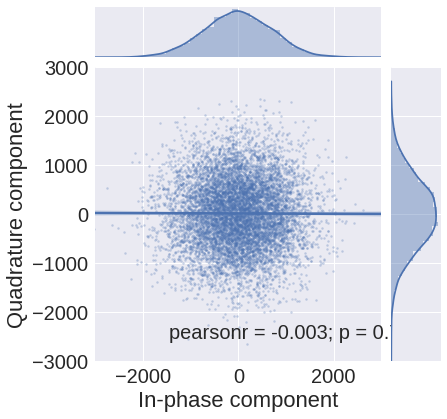

In [5]:
seaborn.jointplot(complex_noisy_samples.real, complex_noisy_samples.imag, kind="reg", size=6, joint_kws={"scatter_kws": {"s":6, "alpha":0.3}})
plt.xlim(-3000, 3000); plt.ylim(-3000, 3000)
plt.xlabel('In-phase component');  plt.ylabel('Quadrature component')

# Visualize Noise


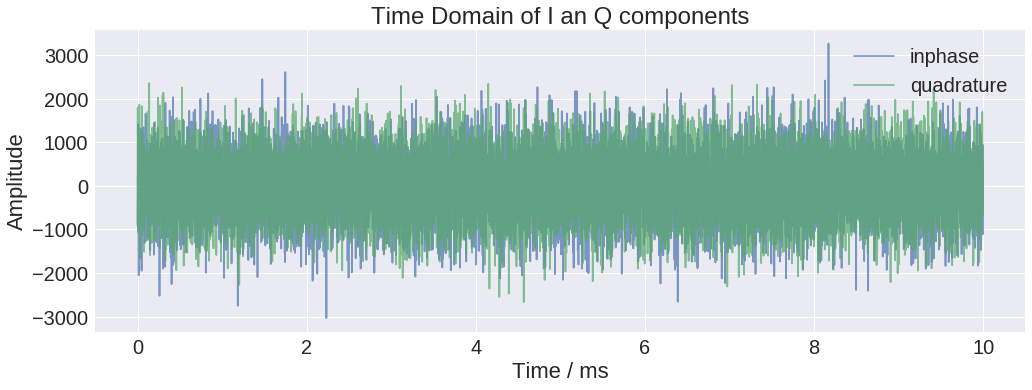

In [6]:
t = np.arange(num_samples) * T_S  # vector of sampling time instances
plt.plot(t*1e3, complex_noisy_samples.real, t*1e3, complex_noisy_samples.imag, alpha=0.7)
plt.title("Time Domain of I an Q components")
plt.xlabel('Time / ms'); plt.ylabel('Amplitude'); plt.legend(('inphase', 'quadrature'));


# Autocorrelation function

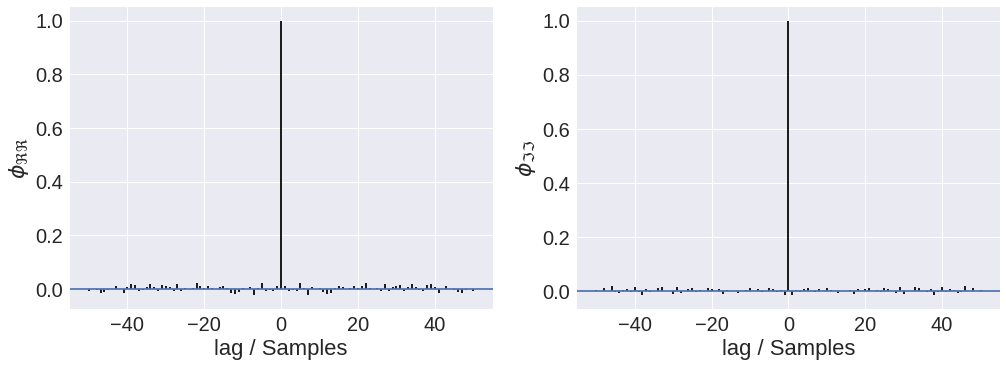

In [7]:
plt.subplot(121)
plt.acorr(complex_noisy_samples.real, usevlines=True, maxlags=50)
plt.ylabel('$\phi_{\Re\Re}$'); plt.xlabel('lag / Samples'); plt.axis('tight')

plt.subplot(122)
plt.acorr(complex_noisy_samples.imag, usevlines=True, maxlags=50)
plt.ylabel('$\phi_{\Im\Im}$'); plt.xlabel('lag / Samples'); plt.axis('tight');

# Histogram & PDF of normal distribution

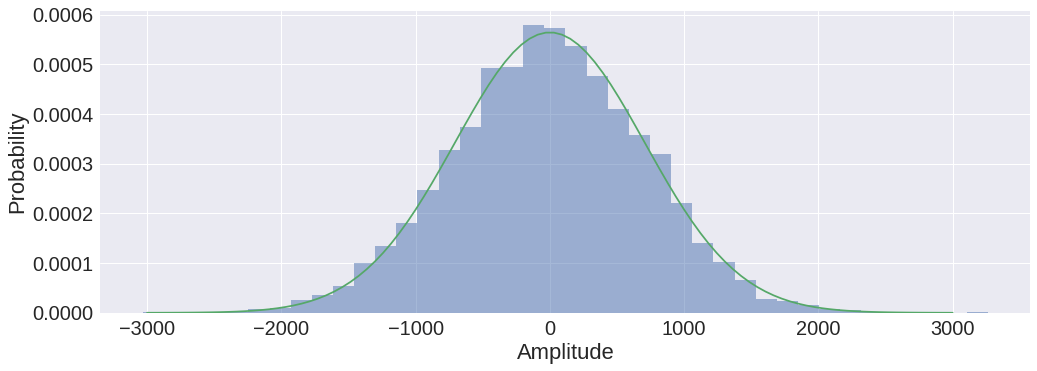

In [8]:
# Plot normalized histogram
plt.hist(complex_noisy_samples.real, bins=40, normed=True, alpha=0.5);
plt.xlabel('Amplitude'); plt.ylabel('Probability')

# Plot normal distribution
x = np.linspace(-3000, 3000, 100)
_ = plt.plot(x,stats.norm.pdf(x,0,sigma))

Amplitudes are normally distributed. Try to play with number of samples and number of bins.

You may also want to take a look at histogram of quadrature component. **What do you expect?**

# Power spectral density using Welch method

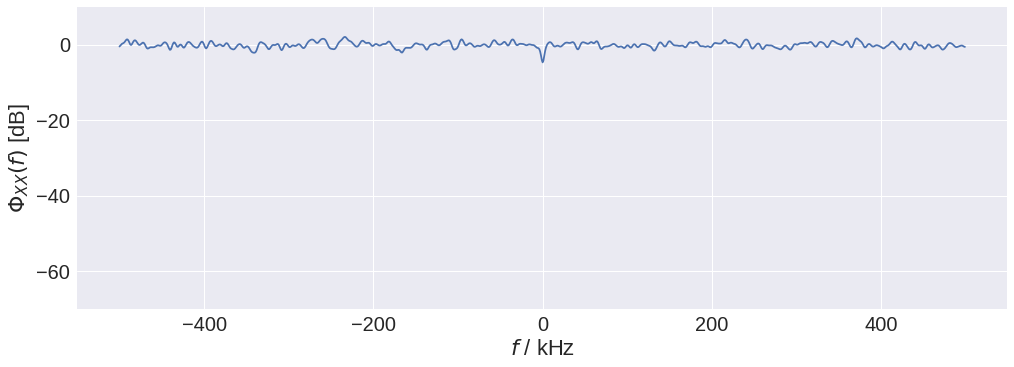

In [9]:
freqs, Pxx = signal.welch(complex_noisy_samples,
                          fs=f_S, nfft=1024, noverlap=0,
                          window="hanning", scaling="density",
                          return_onesided=False)
freqs = np.fft.fftshift(freqs); Pxx = np.fft.fftshift(Pxx)
# Plot PSD, use logarithmic scale:
plt.plot(freqs / 1000, 10*np.log10(np.abs(Pxx)))
plt.ylim(-70, 10)
plt.ylabel('$\Phi_{XX}(f)$ [dB]'); plt.xlabel('$f$ / kHz');

Not quite a constant, why not?

# Low-Pass filtered Gaussian noise

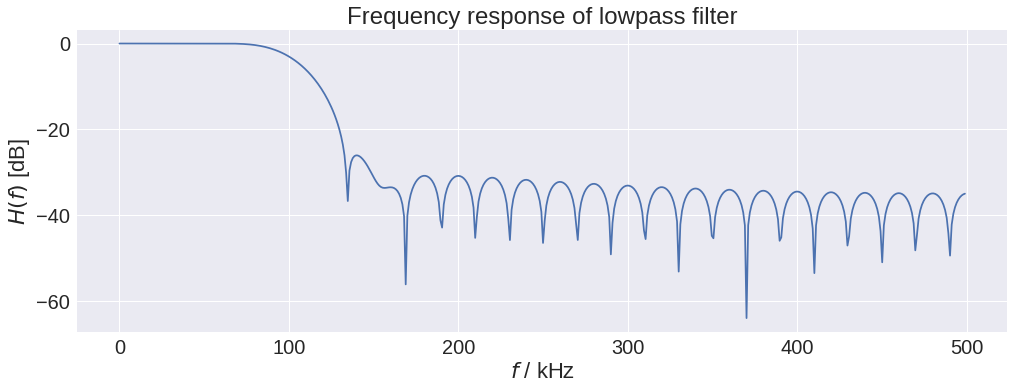

In [10]:
cutoff_freq = 1e5  # cutoff frequency of lowpass filter: 100 kHz
numtaps = 51      # number of filter taps 

# FIR filter design:
lpass_taps = signal.firwin(numtaps, cutoff_freq, nyq=f_nyquist)  #  Get filter taps
freq_norm, response = signal.freqz(lpass_taps) # filter response in frequency domain
freq = freq_norm * f_nyquist / np.pi

# Plot frequency response:
plt.plot(freq / 1e3, 10*np.log10(np.abs(response))) 
plt.title('Frequency response of lowpass filter'); plt.ylabel('$H(f)$ [dB]'); plt.xlabel('$f$ / kHz');

# Filter noisy samples
Actually generate low-pass filtered Gaussian noise.

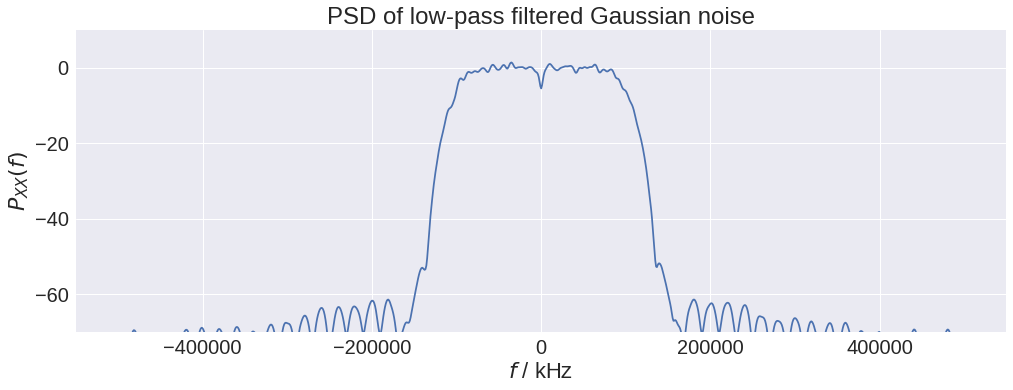

In [11]:
# Filter noise with lowpass:
filtered_x = signal.lfilter(lpass_taps, 1.0, complex_noisy_samples)
# Calculate PSD:
freqs, Pxx = signal.welch(filtered_x,
                          nfft=1024, fs=f_S, window="hanning", noverlap=0, scaling="density", return_onesided=False)
plt.plot(np.fft.fftshift(freqs),
         10*np.log10(np.abs(np.fft.fftshift(Pxx))))
# Plot PSD, use logarithmic scale:
plt.title('PSD of low-pass filtered Gaussian noise');
plt.axis('tight'); plt.ylim(-70, 10); plt.ylabel('$P_{XX}(f)$'); plt.xlabel('$f$ / kHz');

# Autocorrelation function

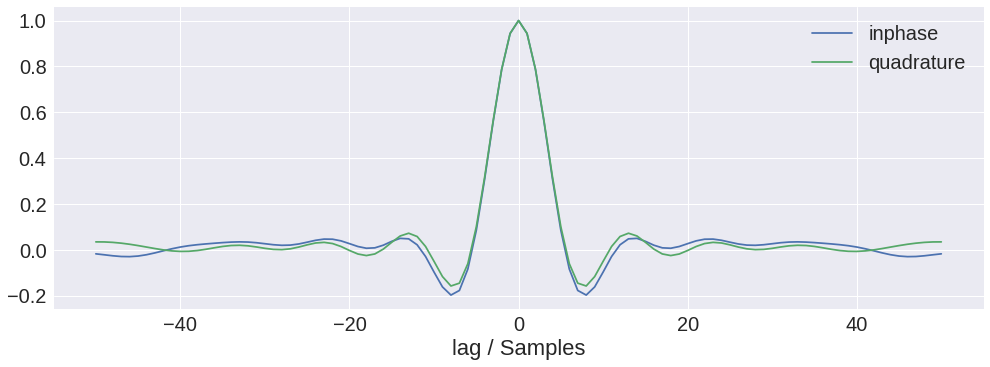

In [12]:
plt.acorr(filtered_x.real, usevlines=False, maxlags=50, marker=None, linestyle='-')
plt.acorr(filtered_x.imag, usevlines=False, maxlags=50, marker=None, linestyle='-')
plt.xlabel('lag / Samples')
plt.legend(('inphase', 'quadrature'));

If you compare this with the autocorrelation function of the unfiltered noise, can you explain what happened?

# Downsampling

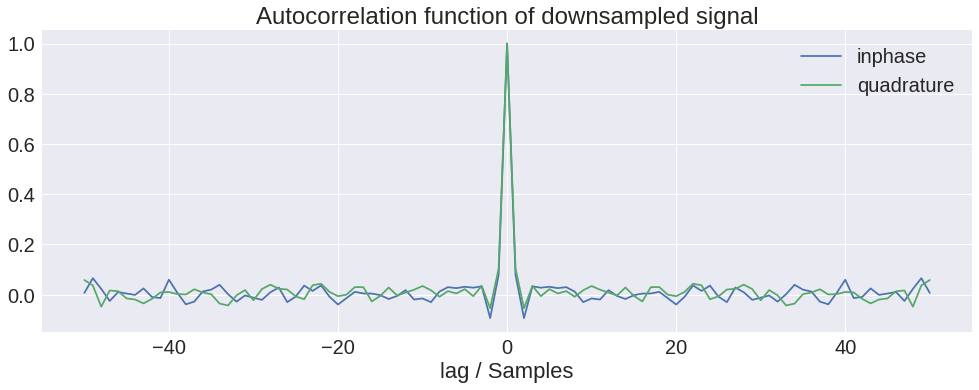

In [13]:
# Take every 5th element of filtered signal
factor = 5; filt_x_dwnsampled = filtered_x[::factor]
plt.acorr(filt_x_dwnsampled.real, usevlines=False, maxlags=50, marker=None, linestyle='-')
plt.acorr(filt_x_dwnsampled.imag, usevlines=False, maxlags=50, marker=None, linestyle='-')
plt.title('Autocorrelation function of downsampled signal')
plt.xlabel('lag / Samples'); plt.axis('tight'); plt.legend(('inphase', 'quadrature'));

What happened? Why did we take every 5th sample? 
Hint: take a look at the cutoff frequency of the filter and at the nyquist frequency.

# PSD after downsampling

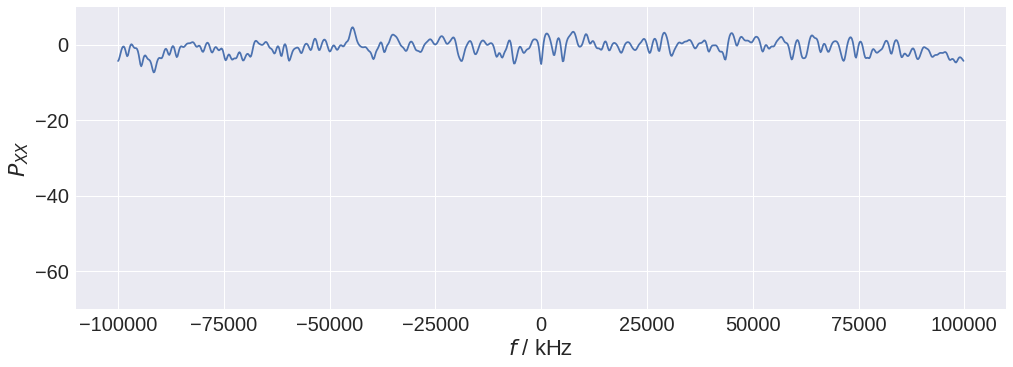

In [14]:
freqs, Pxx = signal.welch(filt_x_dwnsampled,
             fs=f_S/factor,nfft=1024, window="hanning", noverlap=0, scaling="density", return_onesided=False)
# Plot PSD, use logarithmic scale:
plt.plot(np.fft.fftshift(freqs),
         10*np.log10(np.abs(np.fft.fftshift(Pxx))))
plt.axis('tight'); plt.ylim(-70, 10)
plt.ylabel('$P_{XX}$'); plt.xlabel('$f$ / kHz');

Author:  Johannes Fink, April 2016. <br/>
Updates: Marcus Müller <mueller@kit.edu>, May 2018.